#Loading the MNIST dataset

In [67]:
from keras.datasets import mnist
import numpy as np

# Load MNIST dataset from keras
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Number of samples
n = 1000
random_index = np.random.randint(n, size=n) # Randomly select training data
images, labels = (X_train[random_index].reshape(len(X_train[random_index]),28*28)/255, Y_train[random_index])

# Convert train label into one-hot encoding
train_labels = np.zeros((len(labels),10))
for i,l in enumerate(labels):
    train_labels[i][l] = 1

# Flatten the testing data 
test_images = X_test.reshape(len(X_test),28*28)/255

test_labels = np.zeros((len(Y_test),10)) # one-hot encode test labels
for i,l in enumerate(Y_test):
    test_labels[i][l] = 1

print(f'Train Data: {images.shape}, Train Label: {train_labels.shape}, Test Data: {test_images.shape}, Test Label: {test_labels.shape}')

Train Data: (1000, 784), Train Label: (1000, 10), Test Data: (10000, 784), Test Label: (10000, 10)


#Tensor class with autograd

In [68]:
class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        if(id is None):
            self.id = np.random.randint(0,100000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
          
            assert grad.autograd == False

            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
                if(self.creation_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if(self.creation_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if(self.creation_op == "index_select"):
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))
                    
                if(self.creation_op == "cross_entropy"):
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))
                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if(self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)),
                          autograd=True,
                          creators=[self],
                          creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if(self.autograd):
            return Tensor(np.tanh(self.data),
                          autograd=True,
                          creators=[self],
                          creation_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def index_select(self, indices):

        if(self.autograd):
            new = Tensor(self.data[indices.data],
                         autograd=True,
                         creators=[self],
                         creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])
   
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())

#automatic optimization

In [69]:
class SGD(object):
    
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha
    
    def zero(self):
        for p in self.parameters:
            p.grad.data *= 0
        
    def step(self, zero=True):
        
        for p in self.parameters:
            
            p.data -= p.grad.data * self.alpha
            
            if(zero):
                p.grad.data *= 0

#sequential linear layer

In [70]:
class Layer(object):
    
    def __init__(self):
        self.parameters = list()
        
    def get_parameters(self):
        return self.parameters

class Linear(Layer):

    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        W = np.random.randn(n_inputs, n_outputs) * np.sqrt(2.0/(n_inputs))
        self.weight = Tensor(W, autograd=True)
        self.bias = Tensor(np.zeros(n_outputs), autograd=True)
        
        self.parameters.append(self.weight)
        self.parameters.append(self.bias)

    def forward(self, input):
        return input.mm(self.weight)+self.bias.expand(0,len(input.data))

class Sequential(Layer):
    
    def __init__(self, layers=list()):
        super().__init__()
        
        self.layers = layers
    
    def add(self, layer):
        self.layers.append(layer)
        
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input
    
    def get_parameters(self):
        params = list()
        for l in self.layers:
            params += l.get_parameters()
        return params

#activation layer

In [71]:
class Tanh(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.tanh()
    
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.sigmoid()

#loss function

In [72]:
class MSELoss(Layer):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, pred, target):
        return ((pred - target)*(pred - target)).sum(0)
        #return ((pred - target).data ** 2).mean()

#Unit Tests

In [73]:

x = Tensor([1,2,3,4,5], autograd=True)
y = Tensor([2,2,2,2,2], autograd=True) 
z = x + y
z.backward(Tensor(np.array([1,1,1,1,1])))
print(x.grad)
print(y.grad)
print(z.creators)
print(z.creation_op)

[1 1 1 1 1]
[1 1 1 1 1]
[array([1, 2, 3, 4, 5]), array([2, 2, 2, 2, 2])]
add


In [74]:

a = Tensor([1,2,3,4,5], autograd=True)
b = Tensor([2,2,2,2,2], autograd=True)
c = Tensor([5,4,3,2,1], autograd=True)

d = a + b
e = b + c
f = d + e

f.backward(Tensor(np.array([1,1,1,1,1])))

print(b.grad.data == np.array([2,2,2,2,2]))

[ True  True  True  True  True]


In [75]:
a = Tensor([1,2,3,4,5], autograd=True)
b = Tensor([2,2,2,2,2], autograd=True)
c = Tensor([5,4,3,2,1], autograd=True)

d = a + (-b)
e = (-b) + c
f = d + e

f.backward(Tensor(np.array([1,1,1,1,1])))

print(b.grad.data == np.array([-2,-2,-2,-2,-2]))

[ True  True  True  True  True]


#checksum,expand and transpose

In [76]:
x = Tensor(np.array([[1,2,3],
                     [4,5,6]]))
x_t = x.transpose()
print(x.sum(0).data==[5, 7, 9], x.sum(1).data==[ 6, 15])
print()
print(x_t)
print()
print(x.expand(dim=2, copies=4))

[ True  True  True] [ True  True]

[[1 4]
 [2 5]
 [3 6]]

[[[1 1 1 1]
  [2 2 2 2]
  [3 3 3 3]]

 [[4 4 4 4]
  [5 5 5 5]
  [6 6 6 6]]]


#minibatch traning

In [77]:

def train_on_batch(x, y):
  x, y = Tensor(x,autograd=True), Tensor(y,autograd=True)
  y_pred = model.forward(x)
  loss = criterion.forward(y_pred, y)
  loss.backward()
  optim.step()
  return model, loss

In [78]:
data = Tensor(images, autograd=True)
target = Tensor(train_labels, autograd=True)

model = Sequential([Linear(784,200), Tanh() ,Linear(200,80), Tanh(), Linear(80,10), Sigmoid()])
criterion = MSELoss()

optim = SGD(parameters=model.get_parameters(), alpha=0.001)
batch_size = 256
for epoch in range(500):
    for i in range(int(len(data.data)/batch_size)):
      batch_start, batch_end = ((i * batch_size),((i+1)*batch_size))
      model, loss = train_on_batch(data.data[batch_start:batch_end], target.data[batch_start:batch_end])

    if epoch % 50 == 0:
        pred = model.forward(data)
        train_correct = (np.argmax(target.data,axis=1) == np.argmax(pred.data,axis=1)).mean()
        print("Train Accuracy:",train_correct,"Train Loss:", (loss.sum(0).data)/len(data.data))

Train Accuracy: 0.329 Train Loss: 0.22216348707571257
Train Accuracy: 0.952 Train Loss: 0.02597204681394431
Train Accuracy: 0.973 Train Loss: 0.011306361154874612
Train Accuracy: 0.977 Train Loss: 0.0073477530547766436
Train Accuracy: 0.978 Train Loss: 0.005713554653718306
Train Accuracy: 0.978 Train Loss: 0.004875580997684626
Train Accuracy: 0.978 Train Loss: 0.004376545299414445
Train Accuracy: 0.978 Train Loss: 0.003978981488713593
Train Accuracy: 0.98 Train Loss: 0.00338266421627842
Train Accuracy: 0.98 Train Loss: 0.0029356025622354967


#visualization

In [82]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# View the data
def visualize_N_elems_of_dataset(dataset, N, name):
  print("Visualizing the " + name + " dataset.")
  fig = plt.figure(figsize=plt.figaspect(0.3))

  # Plot N elems of the dataset
  for image in range(0, N):
    ax = fig.add_subplot(1, 10, image+1)
    ax.imshow(dataset[image], cmap='Accent')

Visualizing the train dataset.


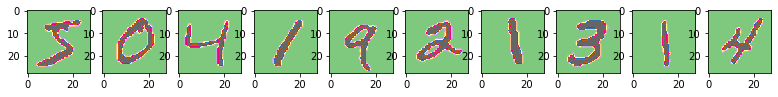

In [83]:

N = 10
visualize_N_elems_of_dataset(X_train, N, "train")